In [ ]:
import pickle
import json
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import ConvexHull
import hdbscan
import warnings
warnings.filterwarnings('ignore')

print('=== embeddings.pkl の確認 ===')
with open('../../dataset/team-mirai/embeddings.pkl', 'rb') as f:
    df_embeddings = pickle.load(f)
    embeddings_array = np.array(df_embeddings['embedding'].tolist())
    print(f'Embeddings array shape: {embeddings_array.shape}')
    print(f'  → {embeddings_array.shape[0]} 個の点、各点は {embeddings_array.shape[1]} 次元')

## タスク1: K=20のk-meansクラスタリング + UMAP可視化

In [ ]:
print('=== タスク1 ステップ1: K=20のk-meansクラスタリング（1536次元空間） ===')
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings_array)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
print(f'クラスタリング完了: {len(set(cluster_labels))} 個のクラスタ')
print(f'クラスタサイズ: 最小={counts.min()}, 最大={counts.max()}, 平均={counts.mean():.1f}')

In [ ]:
print('=== タスク1 ステップ2: UMAPで2次元に次元削減 ===')
umap_model = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embeddings = umap_model.fit_transform(embeddings_array)
print(f'UMAP完了: shape = {umap_embeddings.shape}')

In [ ]:
print('=== タスク1 ステップ3: 散布図と凸包の描画 ===')
colors = cm.tab20(np.linspace(0, 1, 20))
fig, ax = plt.subplots(figsize=(20, 16), dpi=100)

for idx, cluster_id in enumerate(unique_labels):
    cluster_mask = cluster_labels == cluster_id
    cluster_points = umap_embeddings[cluster_mask]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
              c=[colors[idx]], s=10, alpha=0.5, label=f'Cluster {cluster_id}')
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            for simplex in hull.simplices:
                ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                       color=colors[idx], linewidth=1.5, alpha=0.7)
        except: pass

ax.set_title('K-means (K=20) + UMAP', fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig('kmeans20_umap_convexhull.png', dpi=150, bbox_inches='tight')
plt.show()

## タスク2: クラスタ情報を追加した拡張embeddingのUMAP可視化

In [ ]:
print('=== タスク2 ステップ1-2: one-hotエンコーディングと結合 ===')
K = 20
a = 2.0
one_hot = np.zeros((len(cluster_labels), K))
for i, label in enumerate(cluster_labels):
    one_hot[i, label] = a
embeddings_extended = np.hstack([embeddings_array, one_hot])
print(f'拡張後のembeddings shape: {embeddings_extended.shape} (a={a})')

In [ ]:
print('=== タスク2 ステップ3: 拡張embeddingsをUMAPで2次元に次元削減 ===')
umap_model_extended = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embeddings_extended = umap_model_extended.fit_transform(embeddings_extended)
print(f'UMAP完了: shape = {umap_embeddings_extended.shape}')

In [ ]:
print('=== タスク2 ステップ4: 拡張embeddingsの可視化 ===')
fig, ax = plt.subplots(figsize=(20, 16), dpi=100)

for idx, cluster_id in enumerate(unique_labels):
    cluster_mask = cluster_labels == cluster_id
    cluster_points = umap_embeddings_extended[cluster_mask]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
              c=[colors[idx]], s=10, alpha=0.5, label=f'Cluster {cluster_id}')
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            for simplex in hull.simplices:
                ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                       color=colors[idx], linewidth=1.5, alpha=0.7)
        except: pass

ax.set_title(f'K-means (K=20) + Extended Embeddings (a={a}) + UMAP', fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig('kmeans20_extended_umap_convexhull.png', dpi=150, bbox_inches='tight')
plt.show()

## タスク3: HDBSCANクラスタリング + UMAP可視化

In [ ]:
print('=== タスク3 ステップ1: HDBSCANクラスタリング ===')
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, metric='euclidean')
hdbscan_labels = hdbscan_clusterer.fit_predict(embeddings_array)
unique_hdbscan_labels = np.unique(hdbscan_labels)
n_clusters_hdbscan = len(unique_hdbscan_labels[unique_hdbscan_labels >= 0])
n_noise = np.sum(hdbscan_labels == -1)
print(f'クラスタ数: {n_clusters_hdbscan}, ノイズ点数: {n_noise} ({n_noise/len(hdbscan_labels)*100:.1f}%)')

In [ ]:
print('=== タスク3 ステップ2: UMAPで2次元に次元削減 ===')
umap_model_hdbscan = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embeddings_hdbscan = umap_model_hdbscan.fit_transform(embeddings_array)
print(f'UMAP完了: shape = {umap_embeddings_hdbscan.shape}')

In [ ]:
print('=== タスク3 ステップ3: HDBSCANクラスタの可視化 ===')
fig, ax = plt.subplots(figsize=(20, 16), dpi=100)

# ノイズ点
noise_mask = hdbscan_labels == -1
ax.scatter(umap_embeddings_hdbscan[noise_mask, 0], umap_embeddings_hdbscan[noise_mask, 1], 
          c='lightgray', s=2, alpha=0.2, label='Noise', zorder=1)

# クラスタ点
cluster_labels_only = unique_hdbscan_labels[unique_hdbscan_labels >= 0]
n_clusters = len(cluster_labels_only)
if n_clusters <= 20:
    cluster_colors = cm.tab20(np.linspace(0, 1, 20))[:n_clusters]
else:
    cluster_colors = cm.rainbow(np.linspace(0, 1, n_clusters))

for idx, cluster_id in enumerate(cluster_labels_only):
    cluster_mask = hdbscan_labels == cluster_id
    cluster_points = umap_embeddings_hdbscan[cluster_mask]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
              c=[cluster_colors[idx]], s=15, alpha=0.6, label=f'Cluster {cluster_id}', zorder=2)
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            for simplex in hull.simplices:
                ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                       color=cluster_colors[idx], linewidth=2.0, alpha=0.8, zorder=3)
        except: pass

ax.set_title(f'HDBSCAN + UMAP ({n_clusters} clusters, {n_noise} noise)', fontsize=16)
if n_clusters <= 20:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
else:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, ncol=2)
plt.tight_layout()
plt.savefig('hdbscan_umap_convexhull.png', dpi=150, bbox_inches='tight')
plt.show()

## タスク4: HDBSCANラベルを使ったSupervised UMAP可視化

In [ ]:
print('=== タスク4 ステップ1: Supervised UMAPで2次元に次元削減 ===')
print(f'教師信号: クラスタ数={n_clusters_hdbscan}, ノイズ点数={n_noise}')

# クラスタ情報を強く反映させるためのパラメータ調整
# target_weight: クラスタラベル情報の重み (0.0-1.0)
#   0.5: デフォルト（バランス型）
#   0.8-0.95: クラスタ情報を強く反映（推奨）
target_weight = 0.9

umap_model_supervised = UMAP(
    n_components=2, 
    random_state=42, 
    n_neighbors=15, 
    min_dist=0.01,  # 小さくしてクラスタ内の凝集性を高める（デフォルト0.1）
    target_weight=target_weight,  # クラスタ情報の影響度を高める
    metric='euclidean'
)

umap_embeddings_supervised = umap_model_supervised.fit_transform(embeddings_array, y=hdbscan_labels)
print(f'Supervised UMAP完了 (target_weight={target_weight}, min_dist=0.01): shape = {umap_embeddings_supervised.shape}')

=== タスク4 ステップ1: Supervised UMAPで2次元に次元削減 ===
教師信号: クラスタ数=11, ノイズ点数=19746


KeyboardInterrupt: 

In [ ]:
print('=== タスク4 ステップ2: Supervised UMAPの可視化 ===')
fig, ax = plt.subplots(figsize=(20, 16), dpi=100)

# ノイズ点
noise_mask = hdbscan_labels == -1
ax.scatter(umap_embeddings_supervised[noise_mask, 0], umap_embeddings_supervised[noise_mask, 1], 
          c='lightgray', s=2, alpha=0.2, label='Noise', zorder=1)

# クラスタ点
for idx, cluster_id in enumerate(cluster_labels_only):
    cluster_mask = hdbscan_labels == cluster_id
    cluster_points = umap_embeddings_supervised[cluster_mask]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
              c=[cluster_colors[idx]], s=15, alpha=0.6, label=f'Cluster {cluster_id}', zorder=2)
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            for simplex in hull.simplices:
                ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                       color=cluster_colors[idx], linewidth=2.0, alpha=0.8, zorder=3)
        except: pass

ax.set_title(f'HDBSCAN + Supervised UMAP (target_weight={target_weight})\n{n_clusters} clusters, {n_noise} noise points', fontsize=16)
if n_clusters <= 20:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
else:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, ncol=2)
plt.tight_layout()
plt.savefig('hdbscan_supervised_umap_convexhull.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:

# クラスタ情報を強く反映させるためのパラメータ調整
# target_weight: クラスタラベル情報の重み (0.0-1.0)
#   0.5: デフォルト（バランス型）
#   0.8-0.95: クラスタ情報を強く反映（推奨）
target_weight = 0.5

umap_model_supervised = UMAP(
    n_components=2, 
    random_state=42, 
    n_neighbors=15, 
    min_dist=0.1,
    target_weight=target_weight,  # クラスタ情報の影響度を高める
    metric='euclidean'
)

# hdbscan_labelsはノイズ点を-1にするが、UMAPはこれを未ラベルと判断してしまう
# ノイズ点のラベル-1を0に変換してUMAPが使えるようにする
hdbscan_labels_for_umap = hdbscan_labels + 1  # -1→0, 0→1, 1→2, ...
umap_embeddings_supervised = umap_model_supervised.fit_transform(embeddings_array, y=hdbscan_labels_for_umap)
print(f'Supervised UMAP完了 (target_weight={target_weight}, min_dist=0.01): shape = {umap_embeddings_supervised.shape}')

Supervised UMAP完了 (target_weight=0.5, min_dist=0.01): shape = (21348, 2)


=== タスク4 ステップ2: Supervised UMAPの可視化 ===


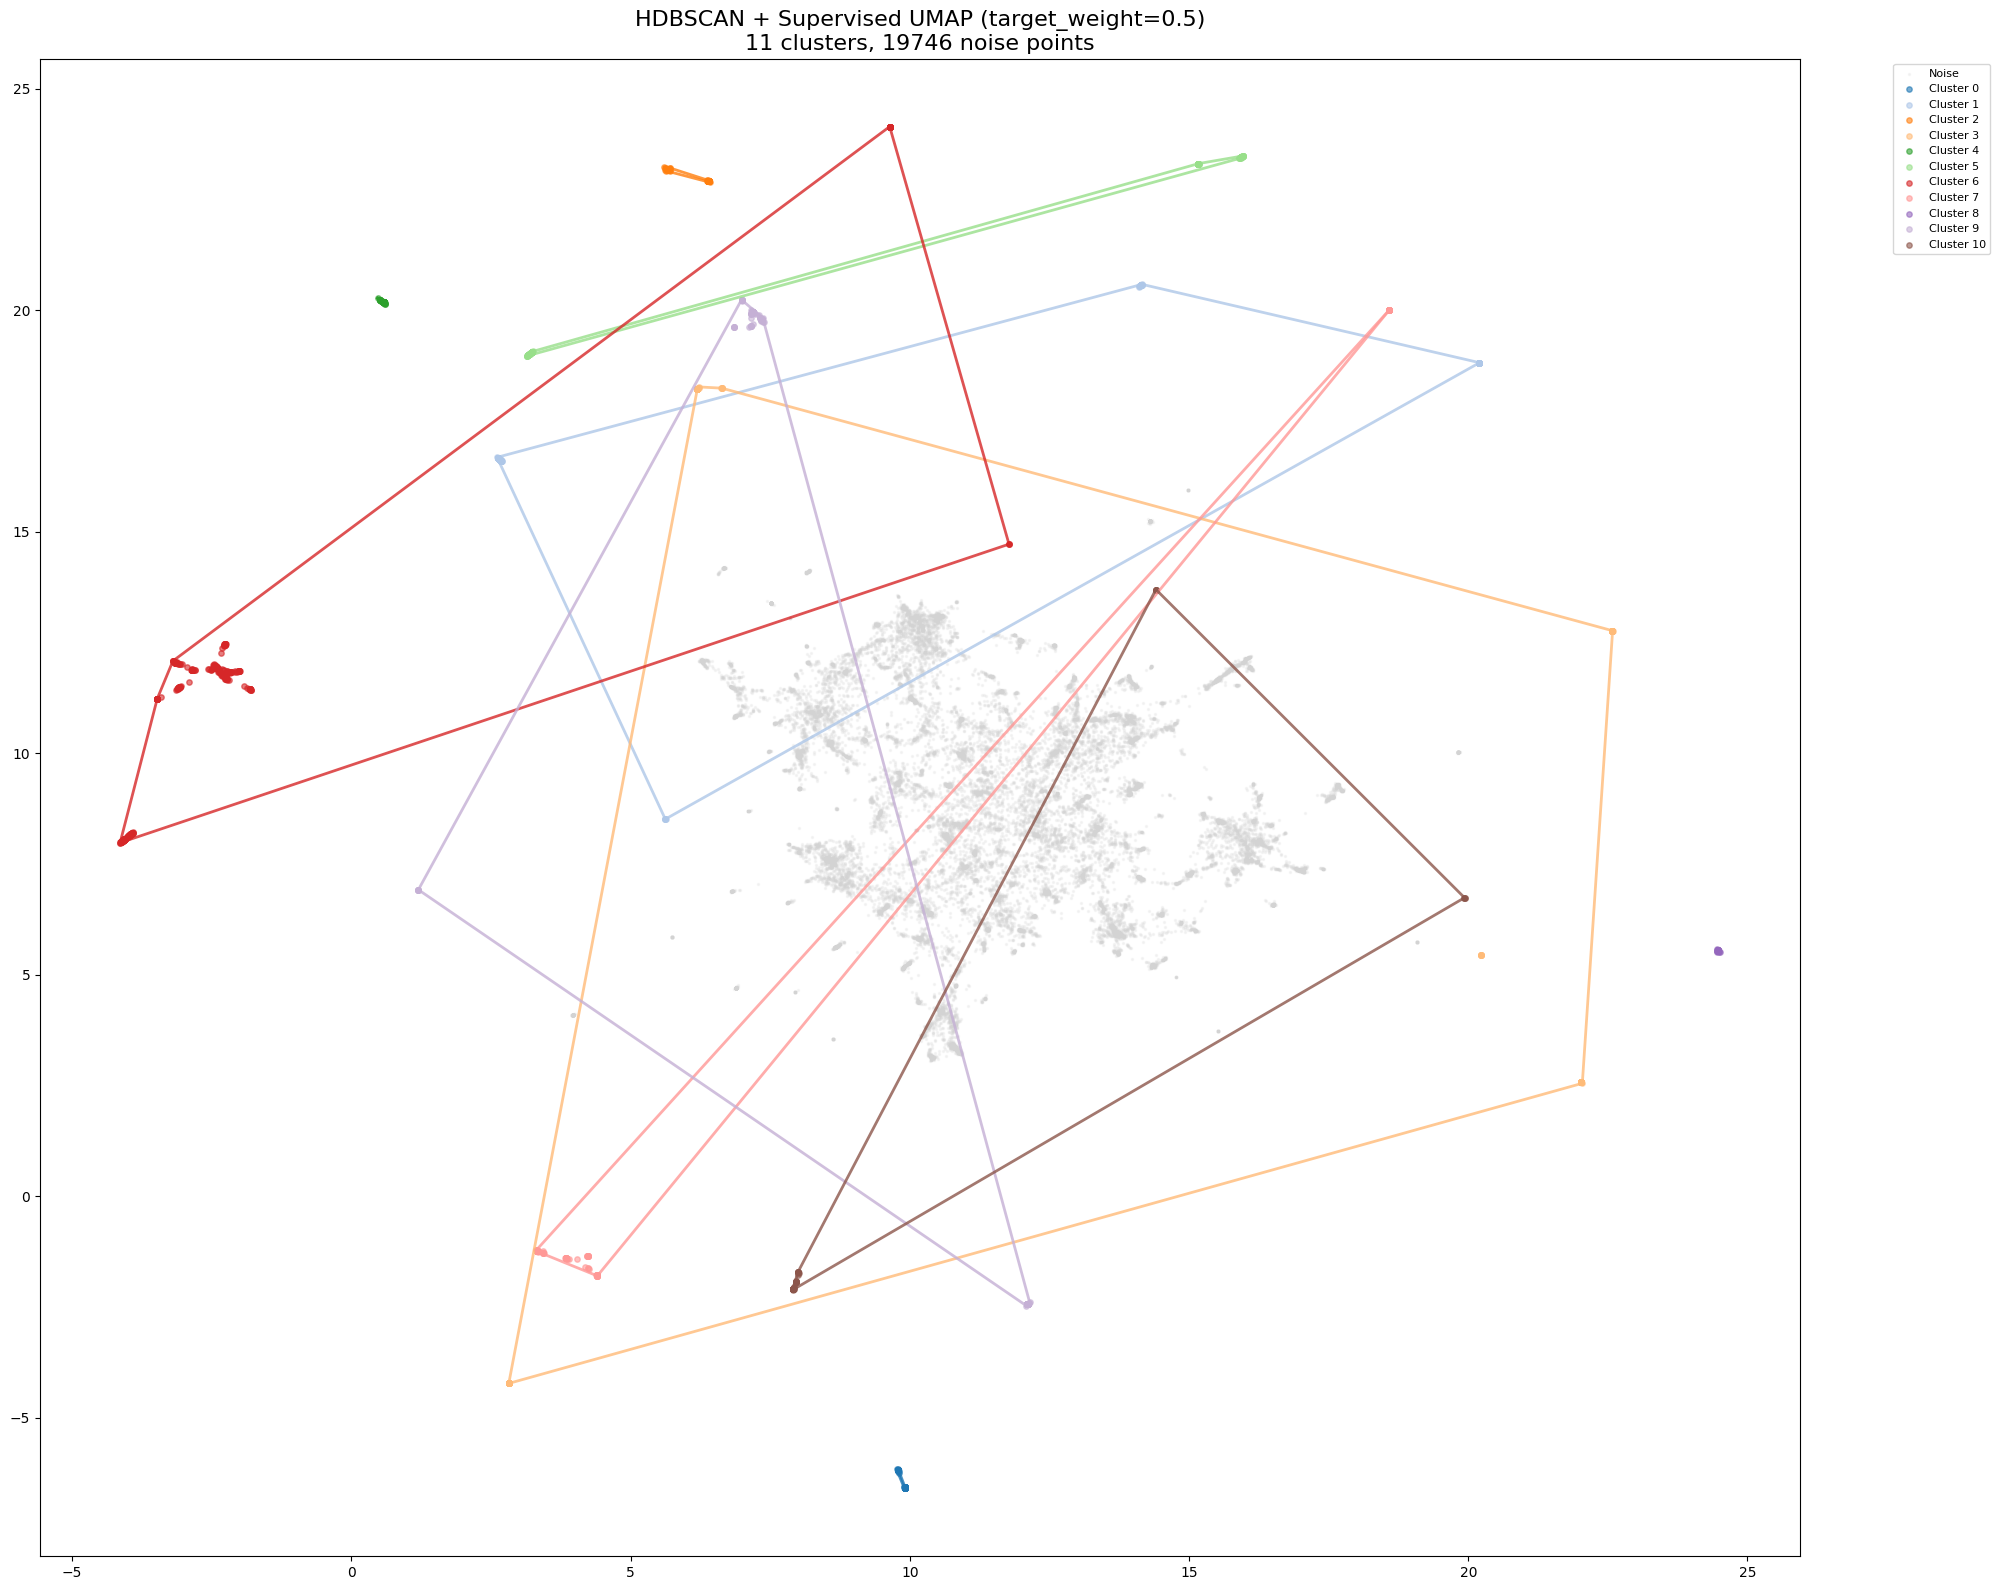

In [54]:
print('=== タスク4 ステップ2: Supervised UMAPの可視化 ===')
fig, ax = plt.subplots(figsize=(20, 16), dpi=100)

# ノイズ点
noise_mask = hdbscan_labels == -1
ax.scatter(umap_embeddings_supervised[noise_mask, 0], umap_embeddings_supervised[noise_mask, 1], 
          c='lightgray', s=2, alpha=0.2, label='Noise', zorder=1)

# クラスタ点
for idx, cluster_id in enumerate(cluster_labels_only):
    cluster_mask = hdbscan_labels == cluster_id
    cluster_points = umap_embeddings_supervised[cluster_mask]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
              c=[cluster_colors[idx]], s=15, alpha=0.6, label=f'Cluster {cluster_id}', zorder=2)
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            for simplex in hull.simplices:
                ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                       color=cluster_colors[idx], linewidth=2.0, alpha=0.8, zorder=3)
        except: pass

ax.set_title(f'HDBSCAN + Supervised UMAP (target_weight={target_weight})\n{n_clusters} clusters, {n_noise} noise points', fontsize=16)
if n_clusters <= 20:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
else:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, ncol=2)
plt.tight_layout()
plt.savefig('hdbscan_supervised_umap_convexhull.png', dpi=150, bbox_inches='tight')
plt.show()

## タスク5: K-meansラベルを使ったSupervised UMAP可視化

K-meansのクラスタリング結果を教師信号として、Supervised UMAPで2次元に次元削減します。K-meansはすべての点をクラスタに割り当てるため、ノイズ点がなく、より明確な分離が期待できます。

In [48]:
print('=== タスク5 ステップ1: K-meansラベルを使ったSupervised UMAP ===')
print(f'教師信号: K-meansクラスタ数={len(unique_labels)}, ノイズ点=0')

# K-meansのラベルを教師信号として使用（ノイズ点なし）
target_weight = 0.9

umap_model_kmeans_supervised = UMAP(
    n_components=2, 
    random_state=42, 
    n_neighbors=15, 
    min_dist=0.01,
    target_weight=target_weight,
    metric='euclidean'
)

umap_embeddings_kmeans_supervised = umap_model_kmeans_supervised.fit_transform(embeddings_array, y=cluster_labels)
print(f'Supervised UMAP完了 (K-means, target_weight={target_weight}): shape = {umap_embeddings_kmeans_supervised.shape}')

=== タスク5 ステップ1: K-meansラベルを使ったSupervised UMAP ===
教師信号: K-meansクラスタ数=20, ノイズ点=0
Supervised UMAP完了 (K-means, target_weight=0.9): shape = (21348, 2)


=== タスク5 ステップ2: K-means Supervised UMAPの可視化 ===
図を kmeans_supervised_umap_convexhull.png に保存しました


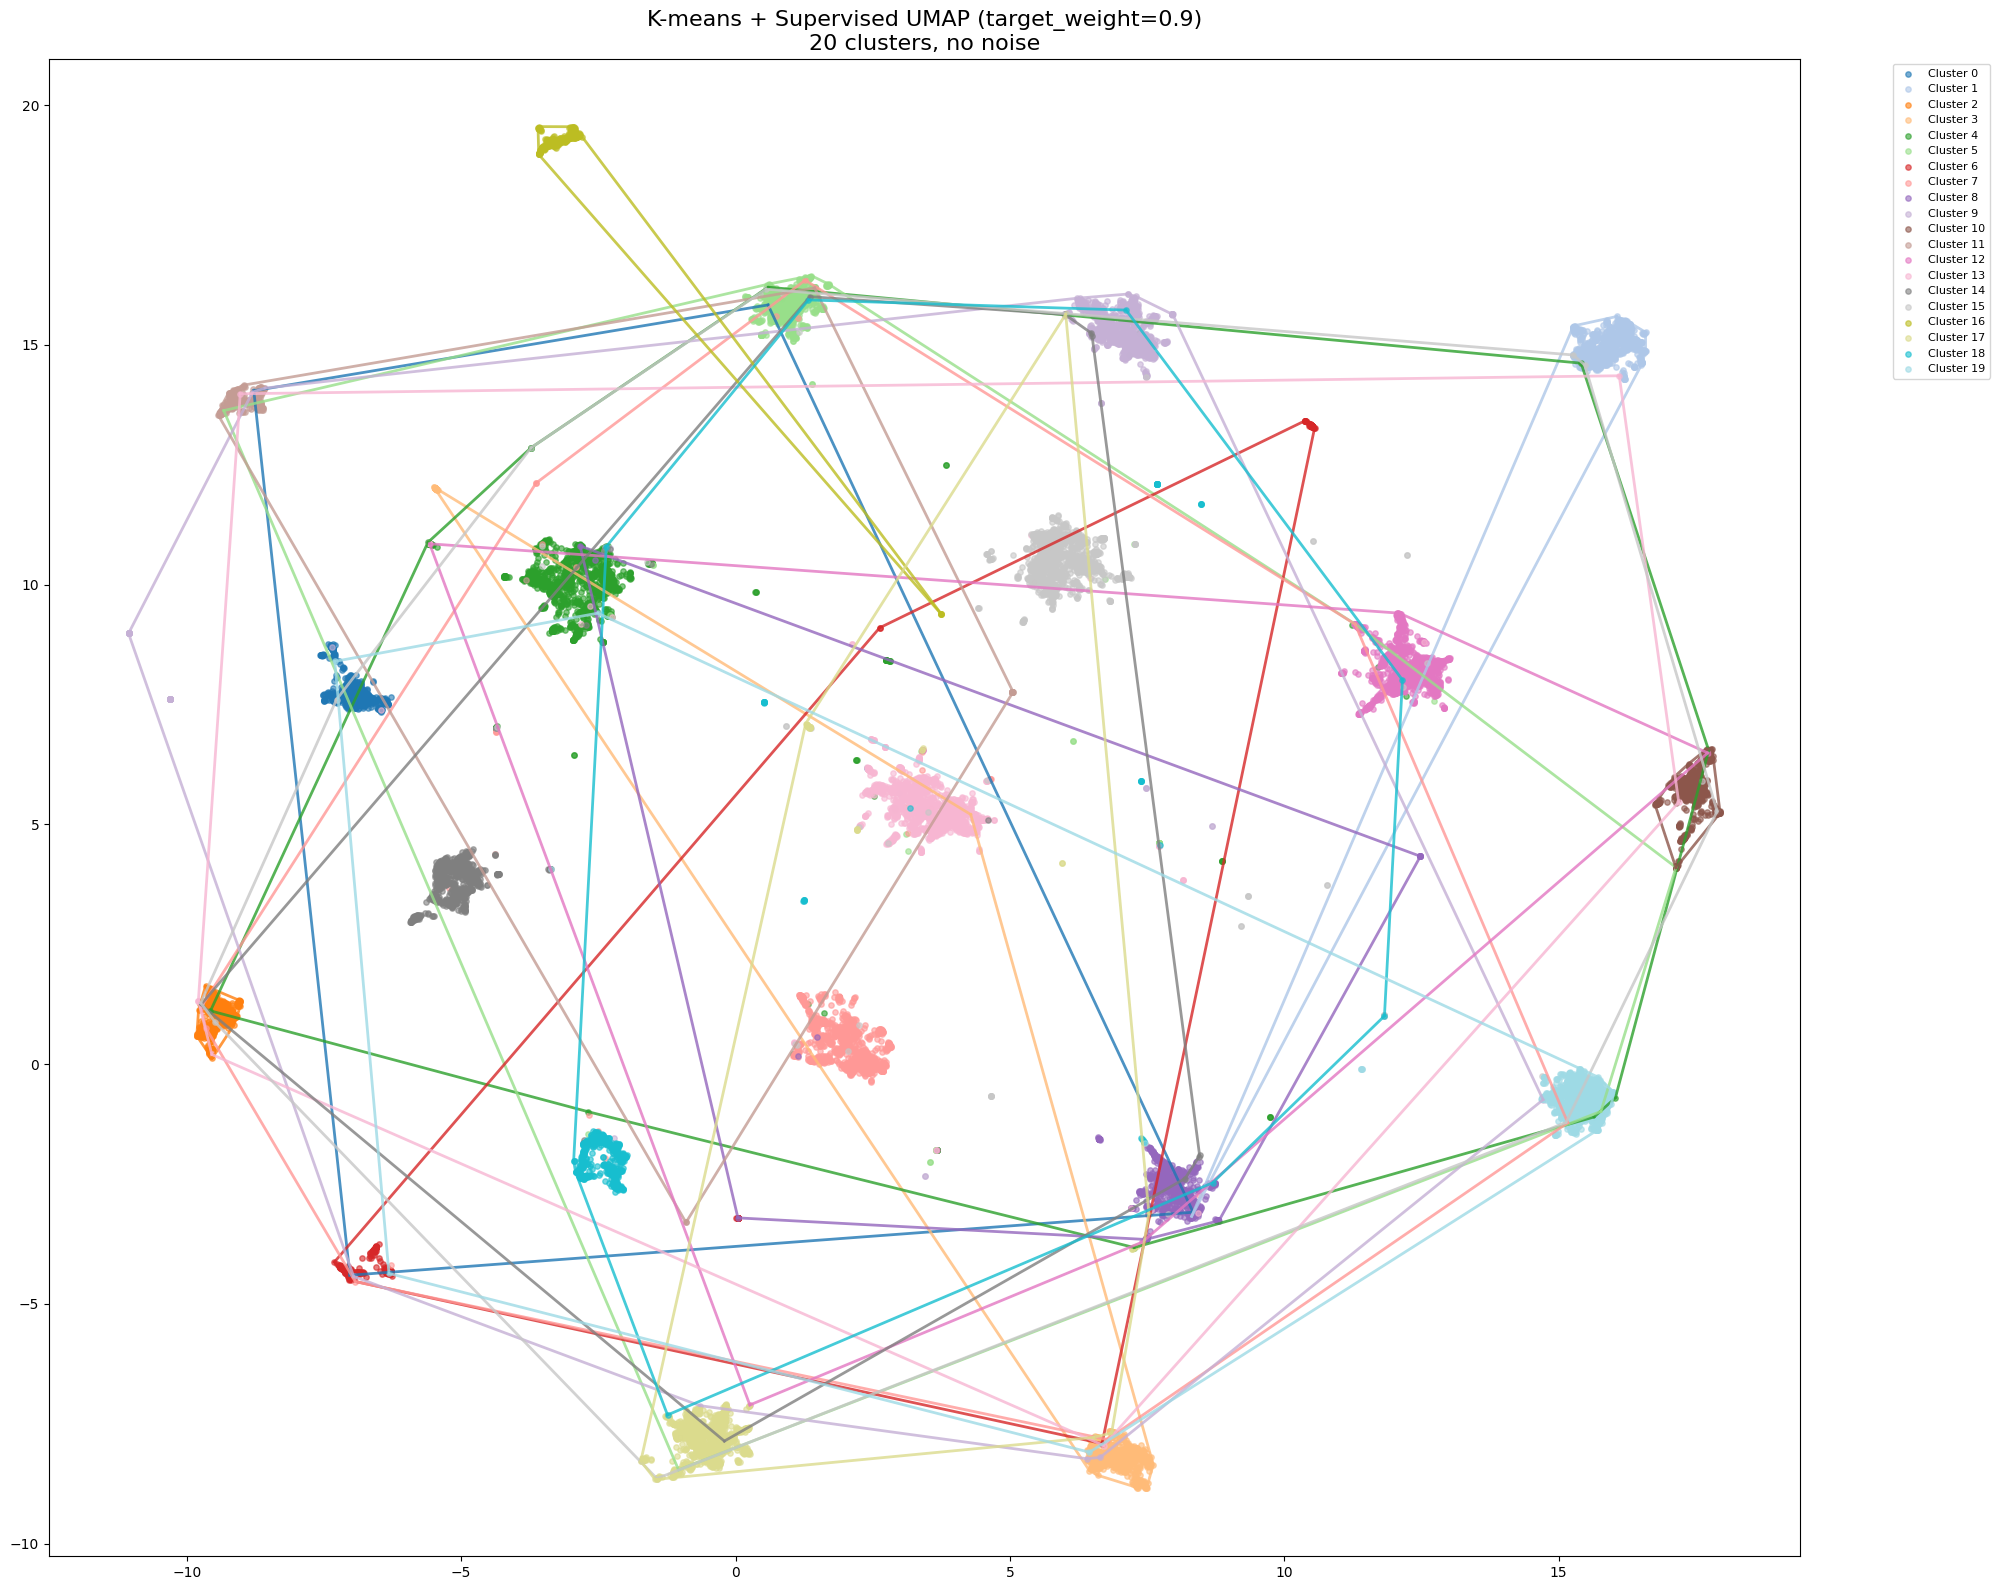

In [49]:
print('=== タスク5 ステップ2: K-means Supervised UMAPの可視化 ===')
fig, ax = plt.subplots(figsize=(20, 16), dpi=100)

# すべての点がクラスタに属する（ノイズ点なし）
for idx, cluster_id in enumerate(unique_labels):
    cluster_mask = cluster_labels == cluster_id
    cluster_points = umap_embeddings_kmeans_supervised[cluster_mask]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
              c=[colors[idx]], s=15, alpha=0.6, label=f'Cluster {cluster_id}', zorder=2)
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            for simplex in hull.simplices:
                ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                       color=colors[idx], linewidth=2.0, alpha=0.8, zorder=3)
        except: pass

ax.set_title(f'K-means + Supervised UMAP (target_weight={target_weight})\n{len(unique_labels)} clusters, no noise', fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig('kmeans_supervised_umap_convexhull.png', dpi=150, bbox_inches='tight')
print('図を kmeans_supervised_umap_convexhull.png に保存しました')
plt.show()